In [19]:
import pandas as pd
import math

# Open the csv file of actors
actors = pd.read_csv('actors.csv')

# Open the csv file of awards
awards = pd.read_csv('data_csv_awards.csv')

# Open the movie tsv file
movies = pd.read_csv('movie_summaries_ada/movie.metadata.tsv', sep='\t', header=None)
# Define the columns
movies.columns = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'revenue', 'runtime', 
                  'languages', 'countries', 'genres']

# Open the character.metadata.tsv file
characters = pd.read_csv('movie_summaries_ada/character.metadata.tsv', sep='\t', header=None)
# Define the columns of the character file
characters.columns = ['wikipedia_movie_id','freebase_movie_id','movie_release_date',
                      'character_name','actor_birth','actor_gender','actor_height',
                      'actor_etnicity','actor_name','actor_age_at_release',
                      'freebase_char_actor_map_id','freebase_character_id','freebase_actor_id']

# 1. Movies Dataset:

In [20]:
# There are 81741 rows
print("Original size: "+str(len(movies['wikipedia_id'])))
# Check for duplicate wikipedia_id or name, every line is indeed unique but there are 
# duplicates in the name column
print("Number of unique names: "+str(len(movies['name'].unique())))
print("Number of unique wiki ids: "+str(len(movies['wikipedia_id'].unique())))
# Show an example of duplicated name, differ in the release date, and runtime
# Key identifier is the (name, release_date, runtime) tuple
# Check for duplicates in the tuple
print("Number of unique tuples: "+str(len(movies.groupby(['name','release_date','runtime']))))
# Show an example of duplicated tuple
# Effective size is 81699 rows from now on
# Record the duplicates names in a list
duplicates = movies[movies.duplicated(['name','release_date','runtime'])]
print("Number of duplicates: "+str(len(duplicates)))
# Remove the duplicates keeping the row with the highest revenue
movies = movies.sort_values('revenue', ascending=False).drop_duplicates(['name','release_date',
                                                                         'runtime']).sort_index()
print("New size without duplicates: "+str(len(movies['wikipedia_id'])))
# Need to transform the release_date column to year because of IMBd dataset
movies['year_release'] = pd.to_datetime(movies["release_date"], infer_datetime_format=True, 
                                        errors="coerce").dt.year


Original size: 81741
Number of unique names: 75478
Number of unique wiki ids: 81741
Number of unique tuples: 81699
Number of duplicates: 42
New size without duplicates: 81699


Percentage of NaNs in each column: 
wikipedia_id     0.000000
freebase_id      0.000000
name             0.000000
release_date     8.407692
revenue         89.717132
runtime         24.986842
languages        0.000000
countries        0.000000
genres           0.000000
year_release     8.408916
dtype: float64
Statistics for revenue: 
count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: revenue, dtype: float64
Distribution of genres: 
{"/m/07s9rl0": "Drama"}                                                                                                                                                                     6848
{}                                                                                                                                                                                          2288
{"/m/01z4y": "Comedy"}                         

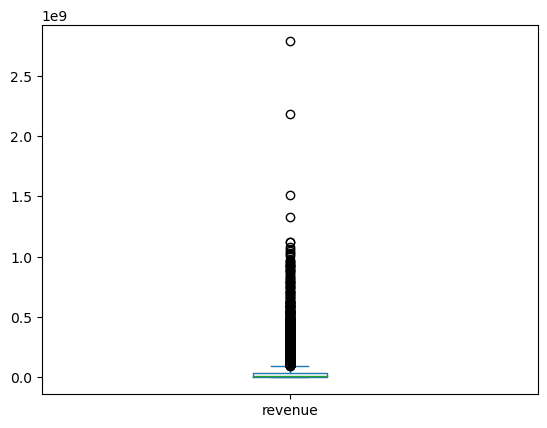

In [21]:
# Check for outliers, percentage of NaNs in each column and distributions (min, max, mean, std)
# Compute percentage of NaNs in each column 
print("Percentage of NaNs in each column: ")
print(movies.isnull().sum()/len(movies)*100)
# Compute statistics for revenue
print("Statistics for revenue: ")
print(movies['revenue'].describe())
# Plot the distribution of revenue with point cloud
movies['revenue'].plot(kind='box')

# Compute the distribution of genres
print("Distribution of genres: ")
print(movies['genres'].value_counts())
# There is a lot of subcategories, probably need to group them. 2k NaNs and 6k Drama 
# (3 times as much as next one)

We clearly have some outliers for the revenue metric, and only `10%` of the movies have this information. On the other hand, we will drop all the movies that have NaNs in our key tuple. Therefore the dataset has no other NaNs than the revenue that will be analyzed in the last question.

In [22]:
# Need to drop NaNs in the runtime, release year and name column in order to be able 
# to correctly identify the movies
movies = movies.dropna(subset=['runtime','year_release','name'])

# Runtime is int in IMBd dataset and float in the other one, need to convert it to int 
# with a ceiling
movies['runtime'] = movies['runtime'].apply(lambda x: int(math.ceil(x)))
# Transform the year_release column to int
movies['year_release'] = movies['year_release'].astype(int)

# Print new size of movies (58k)
print("New size after dropping NaNs: "+str(len(movies['wikipedia_id'])))

New size after dropping NaNs: 58624


In [23]:
# Load the heavy files aka titles imbd to find the imdb unique id, then use it to find 
# the imdb rating and merge it with the movies dataframe
titles_imbd = pd.read_csv('IMDB/title.basics.tsv', sep='\t')
# Keep only the columns we need
titles_imbd = titles_imbd[['tconst','primaryTitle','startYear','runtimeMinutes']]

# Load the imdb rating file
rating_imbd = pd.read_csv('IMDB/title.ratings.tsv', sep='\t')

/var/folders/nb/6_kh75dx3xb3cgzlclgmvcx00000gn/T/ipykernel_2050/4108751658.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles_imbd = pd.read_csv('IMDB/title.basics.tsv', sep='\t')


In [24]:
# Replacing the \N values with NaN
titles_imbd = titles_imbd.replace('\\N', pd.np.nan)
# Drop the rows with NaN values
titles_imbd = titles_imbd.dropna()

# Convert the startYear and runtimeMinutes column to numbers
titles_imbd['startYear'] = titles_imbd['startYear'].astype(int)
titles_imbd['runtimeMinutes'] = titles_imbd['runtimeMinutes'].astype(int)

# Drop duplicates from the titles_imbd dataframe if the tuple (primaryTitle, startYear, 
# runtimeMinutes) is duplicated
titles_imbd = titles_imbd.sort_values('runtimeMinutes', ascending=False).drop_duplicates(
                ['primaryTitle','startYear','runtimeMinutes']).sort_index()

# Merge the ratings_imbd dataframe with the titles_imbd dataframe
titles_imbd = titles_imbd.merge(rating_imbd, on='tconst')

# Show size of the dataframe
print("Size of titles_imbd: "+str(len(titles_imbd['tconst'])))

/var/folders/nb/6_kh75dx3xb3cgzlclgmvcx00000gn/T/ipykernel_2050/1834199833.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  titles_imbd = titles_imbd.replace('\\N', pd.np.nan)


Size of titles_imbd: 954273


In [25]:
# Merge the movies dataframe with the titles_imbd dataframe
movies = movies.merge(titles_imbd, left_on=['name','year_release','runtime'], 
                      right_on=['primaryTitle','startYear','runtimeMinutes'], how='left')
# Drop the useless columns
movies = movies.drop(columns=['primaryTitle','startYear','runtimeMinutes','tconst'])

# Show new size of movies after merging with imdb
print("New size after merging with imdb: "+str(len(movies['wikipedia_id'])))

# 44.4% of the movies have a rating
print(str(movies.averageRating.count())+' movies have a rating over '+
      str(movies.name.count())+' movies, so '+
      str(round(movies.averageRating.count()*100/movies.name.count()))+
      ' % movies do have a rating')

# We drop all the movies that don't have a rating because it is our dependent variable
movies = movies.dropna(subset=['averageRating'])

# Show new size of movies after dropping movies without rating (25k)
print("New size after dropping movies without rating: "+str(len(movies['wikipedia_id'])))
# Show size of the dataframe
print(movies.shape)

New size after merging with imdb: 58624
25515 movies have a rating over 58624 movies, so 44 % movies do have a rating
New size after dropping movies without rating: 25515
(25515, 12)


As we can see, using our triple unique key `(name,release_year,runtime)` and filtering for all the movies we can correctly identify with this, we obtain 25515 movies with rating. This is the dependent variable for all our questions, therefore we have enought to do our analysis.

# 2. Actors Dataset:

In [26]:
# Filter the awards dataframe to only keep the rows with category containing ACTOR or ACTRESS
awards_actors = awards[awards.category.str.contains('ACTOR|ACTRESS')]

# Count the number of awards per entity in awards_actors
awards_actors_count = awards_actors.groupby('entity',as_index=False).count()

In [27]:
# Get a list of unique actors from the character dataframe
actors_list = pd.DataFrame(characters.actor_name.unique())
print(actors_list.shape)

# Rename the column
actors_list.columns = ['name']

# Add a column to the actors_list dataframe with the winners count
actors_list = actors_list.merge(awards_actors_count[['entity','winner']], left_on='name', 
                                right_on='entity', how='left')

# Drop the entity column
actors_list = actors_list.drop(columns=['entity'])

# Rename the count column
actors_list = actors_list.rename(columns={'winner': 'awards'})

# Fill the NaN values in the awards column with 0
actors_list['awards'] = actors_list['awards'].fillna(0)
print(actors_list.shape)

# Create a dataframe with the number of movies per actor
actors_movies_count = pd.DataFrame(characters.actor_name.value_counts())

# Add a column to the actors_list dataframe with the movies count
actors_list = actors_list.merge(actors_movies_count, left_on='name', right_index=True, how='left')
# Rename the count column
actors_list = actors_list.rename(columns={'actor_name': 'movies'})
print(actors_list.shape)

# Replace the Actor column of actors dataframe by the same value but replace each _ by a space
actors['Actor'] = actors['Actor'].str.replace('_', ' ')

# Add the actors dataframe to the actors_list dataframe on the Actor column and name column respectively
actors_list = actors_list.merge(actors, left_on='name', right_on='Actor', how='left')

# Drop the Actor column
actors_list = actors_list.drop(columns=['Actor'])
print(actors_list.shape)

# Print the number of actors with a Fame value
print(str(actors_list.Fame.count()) + ' actors have a Fame value over ' 
      + str(actors_list.name.count()) + ' actors, so ' 
      + str(round(actors_list.Fame.count() * 100/actors_list.name.count())) 
      + ' % actors do have a Fame value')

# Replace the NaN values in the Fame, Liked, Disliked, Neutral columns by 0
actors_list['Fame'] = actors_list['Fame'].fillna(0)
actors_list['Liked'] = actors_list['Liked'].fillna(0)
actors_list['Disliked'] = actors_list['Disliked'].fillna(0)
actors_list['Neutral'] = actors_list['Neutral'].fillna(0)

#TODO: issue to solve, we loose about 46 actors in the merge because the name has . or ' or -, and we replace every _ by a space
#TODO: possible solution, replace every . or ' or - by a space in the actors_list dataframe
#TODO: possible solution, replace every . or ' or - or space by a _ in the actors dataframe

(134079, 1)
(134079, 2)
(134079, 3)
(134079, 7)
1310 actors have a Fame value over 134078 actors, so 1 % actors do have a Fame value


In [28]:
# Make a pandas dataframe of the characters dataframe with only the first row of each actor
actors_metadata = characters.drop_duplicates(subset=['actor_name'], keep='first')

# Drop the columns that we don't need
actors_metadata = actors_metadata.drop(columns=['wikipedia_movie_id', 'freebase_movie_id', 
                                                'movie_release_date', 'character_name',
                                                'actor_age_at_release', 
                                                'freebase_char_actor_map_id', 
                                                'freebase_character_id'])
actors_metadata.head()

,actor_birth,actor_gender,actor_height,actor_etnicity,actor_name,freebase_actor_id
0,1958-08-26,F,1.620,NaN,Wanda De Jesus,/m/03wcfv7
1,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,/m/0346l4
2,1969-06-15,M,1.727,/m/0x67,Ice Cube,/m/01vw26l
3,1967-09-12,M,1.750,NaN,Jason Statham,/m/034hyc
4,1977-09-25,F,1.650,NaN,Clea DuVall,/m/01y9xg


In [29]:
actors_info = actors_metadata.merge(actors_list, left_on='actor_name', right_on='name', 
                                    how='left')
actors_info = actors_info.drop(columns=['name'])
print(actors_info.shape)
print(actors_info.head())

(134079, 12)
  actor_birth actor_gender  actor_height actor_etnicity          actor_name  \
0  1958-08-26            F         1.620            NaN      Wanda De Jesus   
1  1974-08-15            F         1.780     /m/044038p  Natasha Henstridge   
2  1969-06-15            M         1.727        /m/0x67            Ice Cube   
3  1967-09-12            M         1.750            NaN       Jason Statham   
4  1977-09-25            F         1.650            NaN         Clea DuVall   

  freebase_actor_id  awards  movies  Fame  Liked  Disliked  Neutral  
0        /m/03wcfv7     0.0     8.0   0.0    0.0       0.0      0.0  
1         /m/0346l4     0.0    23.0   0.0    0.0       0.0      0.0  
2        /m/01vw26l     0.0    33.0  93.0   57.0      11.0     25.0  
3         /m/034hyc     0.0    31.0  78.0   59.0       4.0     14.0  
4         /m/01y9xg     0.0    31.0   0.0    0.0       0.0      0.0  


In [30]:
# Show the percentage of NaNs in each column of actors_info
print("Percentage of NaNs in each column: ")
print(actors_info.isnull().sum()/len(actors_info)*100)

Percentage of NaNs in each column: 
actor_birth          56.755346
actor_gender         28.192334
actor_height         90.464577
actor_etnicity       93.955056
actor_name            0.000746
freebase_actor_id     0.000746
awards                0.000000
movies                0.000746
Fame                  0.000000
Liked                 0.000000
Disliked              0.000000
Neutral               0.000000
dtype: float64


We can observe that we have information for 134079 actors. 

`0.000746%` of them have no name, id or movie, so are useless as they have no information for the movie. On the bright side, we still have `6%` of actors ethnicity and `10%` of gender. This ratio is for unique actors, it represents a much larger sample in the character dataset.

# 3. Character Dataset:

In [31]:
# Show initial size of character dataframe
print("Initial size of characters: "+str(characters.shape))
# Merge additional info of the actors to the characters dataframe
characters = characters.merge(actors_list[['name','Fame','Liked','Disliked','Neutral']], 
                              left_on='actor_name', right_on='name', how='left')
characters = characters.drop(columns=['name'])
# Show new size of characters dataframe
print("New size of the dataset"+str(characters.shape))
# Compute percentage of NaNs in each column
print("Percentage of NaNs in each column: ")
print(characters.isnull().sum()/len(characters)*100)
# Etnicty at 76% missing and gender at 10% missing
# Recomputed later when we remove the movies we don't have the rating for

# Filter out all the character rows which wikipedia_movie_id is not in the movies dataframe
characters = characters[characters.wikipedia_movie_id.isin(movies.wikipedia_id)]
# Show new size of characters dataframe
print("New size of the dataset after removing not reviewed movies: "+str(characters.shape))

# Compute percentage of NaNs in each column
print("Percentage of NaNs in each column: ")
print(characters.isnull().sum()/len(characters)*100)


Initial size of characters: (450669, 13)
New size of the dataset(450669, 17)
Percentage of NaNs in each column: 
wikipedia_movie_id             0.000000
freebase_movie_id              0.000000
movie_release_date             2.217814
character_name                57.220488
actor_birth                   23.552763
actor_gender                  10.120288
actor_height                  65.645740
actor_etnicity                76.466542
actor_name                     0.272484
actor_age_at_release          35.084064
freebase_char_actor_map_id     0.000000
freebase_character_id         57.218269
freebase_actor_id              0.180842
Fame                           0.000000
Liked                          0.000000
Disliked                       0.000000
Neutral                        0.000000
dtype: float64
New size of the dataset after removing not reviewed movies: (171045, 17)
Percentage of NaNs in each column: 
wikipedia_movie_id             0.000000
freebase_movie_id              0.000000
mov

As we can see, we have `21%` of our characters' etnicity, `90%` of our characters' gender and all the fame values, which is 0 if the actor is known by less than 49% of the US population. We therefore have enough data for our both questions. Add to this, we also have `47%` of character types ids, and `78%` of the age at release.

In [32]:
# Get cumulative nomination count per actor (nominations until (including) the current award)
nominations = awards_actors.copy()
nominations['award_cumcount'] = nominations.groupby('entity').cumcount() + 1

# Convert 'movie_release_date' to datetime for merging, using coerce for unparseable dates
# For rows where conversion failed (resulted in NaT), extract the year directly from the string 
# (often just the year is given)
# Leaves rows with no data about movie_release_date as NaT
characters['release_year'] = pd.to_datetime(characters['movie_release_date'], 
                                            errors='coerce').dt.year
characters['release_year'] = characters['release_year'].fillna(characters['movie_release_date']
                                                               .str.extract(r'(\d{4})')[0]
                                                               .astype(float))

#print(characters.release_year.describe()) # TODO Years with 1900 exist.

print(f'No. of NaN release years before merge: {characters["release_year"].isna().sum()}')

# Merge the DataFrames
characters = pd.merge(characters, 
                     nominations[['entity', 'year', 'award_cumcount']], 
                     left_on=['actor_name', 'release_year'],
                     right_on=['entity', 'year'], 
                     how='left')

# Forward fill 'award_cumcount' within each 'actor_name' group for following years till 
# next award
characters = characters.sort_values(by=['actor_name', 'movie_release_date'])
characters['award_cumcount'] = characters.groupby('actor_name')['award_cumcount'].ffill()

# TODO include in markdown: The difference in the following numbers results from dropped 
# rows (cause movie not in other movie dataset)
print(f'Unique cumcounts: {characters[(characters.actor_name == "Katharine Hepburn")
      ]["award_cumcount"].unique()}')
print(f'nominations of Katharine Hepburn: {nominations[nominations["entity"] == 
      "Katharine Hepburn"].count()}')

# After the above steps, 'award_cumcount' will still have NaNs for characters whose actors 
# have no award or until the year of the first award. We replace these NaNs with 0.
characters['award_cumcount'].fillna(0, inplace=True)

# Drop the extra columns
characters.drop(columns=['entity', 'release_year', 'year'], inplace=True)

display(characters.award_cumcount.describe())
characters[characters.award_cumcount == 4].head()

No. of NaN release years before merge: 0
Unique cumcounts: [ 1.  2.  3.  4.  7.  9. 10.]
#nominations of Katharine Hepburn: year              12
category          12
winner            12
entity            12
award_cumcount    12
dtype: int64


count    171060.000000
mean          0.096966
std           0.537525
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: award_cumcount, dtype: float64

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birth,actor_gender,actor_height,actor_etnicity,actor_name,actor_age_at_release,freebase_char_actor_map_id,freebase_character_id,freebase_actor_id,Fame,Liked,Disliked,Neutral,award_cumcount
72641,101914,/m/0ptx_,1975,Sonny,1940-04-25,M,1.7,/m/0xnvg,Al Pacino,34.0,/m/0jxdcl,/m/02nwdcx,/m/0bj9k,93.0,73.0,5.0,15.0,4.0
149416,1880546,/m/06391r,1977,NaN,1940-04-25,M,1.7,/m/0xnvg,Al Pacino,36.0,/m/0k56ng,NaN,/m/0bj9k,93.0,73.0,5.0,15.0,4.0
1869,10594693,/m/02qjrcp,1977-09-29,Bobby Deerfield,1940-04-25,M,1.7,/m/0xnvg,Al Pacino,37.0,/m/02tb2th,/m/09jz80h,/m/0bj9k,93.0,73.0,5.0,15.0,4.0
68570,2075256,/m/06kg0c,1980-02-08,NaN,1940-04-25,M,1.7,/m/0xnvg,Al Pacino,39.0,/m/0jwvcj,NaN,/m/0bj9k,93.0,73.0,5.0,15.0,4.0
128765,3989120,/m/0bb91x,1982-06-18,Ivan Travalian,1940-04-25,M,1.7,/m/0xnvg,Al Pacino,42.0,/m/0jtvfq,/m/0h6fndg,/m/0bj9k,93.0,73.0,5.0,15.0,4.0


We consider the case where an actor plays multiple roles in the same movie; in such case, we make the assumption that one movie and not one role counts as one experience.

In [35]:
# Add Movie Experience
# 1. Clean: Extract Movies from character based df into new df and drop duplicates
# 2. Calc cumcount per actor in this seperate df
# 3. Left Join seperate df onto original df!
# 4. Drop roles of movies we don't look at!

# Copy to work on separate df that we can modify and clean.
characters_movie_exp = characters.copy()

# Drop characters with no unique identifier for an actor
characters_movie_exp = characters_movie_exp.dropna(subset=['freebase_actor_id'])

assert characters_movie_exp.freebase_actor_id.isna().sum() == 0, "Some actors don't have an id"
assert characters_movie_exp.freebase_movie_id.isna().sum() == 0, "Some movies don't have an id"

# Drop actors that played twice in the same movie
characters_movie_exp = characters_movie_exp.drop_duplicates(['freebase_movie_id', 
                                                             'freebase_actor_id'])

# Get cumulative movie count per actor (movies done until (excluding) the current movie) 
# as a measure of prior experience
characters_movie_exp = characters_movie_exp.sort_values(by=['freebase_actor_id', 
                                                            'movie_release_date'])
characters_movie_exp['movies_cumcount'] = characters_movie_exp.groupby(
                                            ['freebase_actor_id']).cumcount()

characters = pd.merge(characters,
                    characters_movie_exp[['freebase_movie_id', 'freebase_actor_id',                           
                                          'movies_cumcount']],
                    on=['freebase_movie_id', 'freebase_actor_id'],
                    how='left' )

# Ensure we have data about the same set of movies to ensure comparability of findings
characters = characters[characters['freebase_movie_id'].isin(movies.freebase_id)].copy()

characters = characters.sort_values(by=['freebase_actor_id', 'movie_release_date'])
characters['movies_cumcount'] = characters.groupby('freebase_actor_id')[
                                    'movies_cumcount'].ffill()

# Drop characters without a name and freebase id. This effectifely drops all NaN 
# movies_cumcount's, as these NaN's were the reason.
characters = characters.dropna(subset=['freebase_actor_id', 'actor_name'], how='all')
print(f'Sum of NaNs in movies_cumcount column: {characters.movies_cumcount.isna().sum()}')

display(characters.movies_cumcount.describe())
characters.head()
display(characters[characters.actor_name == 'Jason Statham'])

Sum of NaNs in movies_cumcount column: 0


count    170812.000000
mean          3.834215
std           6.816008
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max         109.000000
Name: movies_cumcount, dtype: float64

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birth,actor_gender,actor_height,actor_etnicity,actor_name,actor_age_at_release,freebase_char_actor_map_id,freebase_character_id,freebase_actor_id,Fame,Liked,Disliked,Neutral,award_cumcount,movies_cumcount
72174,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.75,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,78.0,59.0,4.0,14.0,0.0,0.0
72175,2976107,/m/08h5ny,2003-05-30,Handsome Rob,1967-09-12,M,1.75,NaN,Jason Statham,35.0,/m/02l07sm,/m/0c1nyzc,/m/034hyc,78.0,59.0,4.0,14.0,0.0,1.0
72176,826409,/m/03f7nt,2004-08-05,Airport Man,1967-09-12,M,1.75,NaN,Jason Statham,36.0,/m/03jps0r,/m/0c1lxk3,/m/034hyc,78.0,59.0,4.0,14.0,0.0,2.0
72177,2409484,/m/07b2jc,2005-08-03,Frank Martin,1967-09-12,M,1.75,NaN,Jason Statham,37.0,/m/0k79lk,/m/026yqk6,/m/034hyc,78.0,59.0,4.0,14.0,0.0,3.0
72178,2581392,/m/07phbc,2006-01-19,Yves Gluant,1967-09-12,M,1.75,NaN,Jason Statham,38.0,/m/03jrscm,/m/0gghg36,/m/034hyc,78.0,59.0,4.0,14.0,0.0,4.0
72179,5795788,/m/0f52ld,2007-08-24,Crawford,1967-09-12,M,1.75,NaN,Jason Statham,39.0,/m/02vbscv,/m/0gxf16_,/m/034hyc,78.0,59.0,4.0,14.0,0.0,5.0
72180,12160883,/m/02vrt_0,2008-02-19,Terry Leather,1967-09-12,M,1.75,NaN,Jason Statham,40.0,/m/03jqy9j,/m/0b_nq1h,/m/034hyc,78.0,59.0,4.0,14.0,0.0,6.0
72181,14708304,/m/03gtwh_,2009-04-16,Chev Chelios,1967-09-12,M,1.75,NaN,Jason Statham,41.0,/m/04m74xb,/m/0410ywf,/m/034hyc,78.0,59.0,4.0,14.0,0.0,7.0
72182,27203385,/m/0bwj49p,2011-01-13,Arthur Bishop,1967-09-12,M,1.75,NaN,Jason Statham,43.0,/m/0cs288l,/m/0g4qhw2,/m/034hyc,78.0,59.0,4.0,14.0,0.0,8.0
72183,33276254,/m/0gffmn8,2012-08-08,Lee Christmas,1967-09-12,M,1.75,NaN,Jason Statham,44.0,/m/0gwhct9,/m/08ldsbl,/m/034hyc,78.0,59.0,4.0,14.0,0.0,9.0


## Update of actors dataset:

In [36]:
# Filter out actors in actors_info that are not in the characters dataframe
actors_info_test = actors_info[actors_info.actor_name.isin(characters.actor_name)]
# Show new size of actors_info dataframe
print("New size of the dataset after removing actors not in characters: "
      + str(actors_info_test.shape))

# Compute percentage of NaNs in each column
print("Percentage of NaNs in each column: ")
print(actors_info_test.isnull().sum()/len(actors_info_test)*100)

New size of the dataset after removing actors not in characters: (70367, 12)
Percentage of NaNs in each column: 
actor_birth          46.001677
actor_gender         21.053903
actor_height         85.655208
actor_etnicity       91.245897
actor_name            0.001421
freebase_actor_id     0.001421
awards                0.000000
movies                0.001421
Fame                  0.000000
Liked                 0.000000
Disliked              0.000000
Neutral               0.000000
dtype: float64


As we can see, filtering out the actors that don't appear in our movies increases the % of information we have in every category.

## Update of Movies dataset:
Adding character info summarized per movie to complete the dataset

In [40]:
movies_test = movies.copy()
# Create a dataset of the average award cumcount per movie from the characters dataframe
values = characters.groupby('freebase_movie_id',as_index=False).mean()
# Merge the movies dataframe with the values dataframe
movies_test = movies_test.merge(values[['freebase_movie_id','award_cumcount','movies_cumcount']],
                                 left_on='freebase_id', right_on='freebase_movie_id', how='left')
# Drop the useless columns
movies_test = movies_test.drop(columns=['freebase_movie_id'])
# Rename the columns as average_award_cumcount and average_movies_cumcount
movies_test = movies_test.rename(columns={'award_cumcount': 'average_award_cumcount',
                                          'movies_cumcount': 'average_movies_cumcount'})
# Use values to store the cumulative values of the movies
values = characters.groupby('freebase_movie_id',as_index=False).sum()
# Merge the movies dataframe with the values dataframe
movies_test = movies_test.merge(values[['freebase_movie_id','award_cumcount','movies_cumcount']],
                                 left_on='freebase_id', right_on='freebase_movie_id', how='left')
# Drop the useless columns
movies_test = movies_test.drop(columns=['freebase_movie_id'])


# Show new size of movies dataframe
print("New size of the dataset after merging with characters: " + str(movies_test.shape))
movies_test.head()



/var/folders/nb/6_kh75dx3xb3cgzlclgmvcx00000gn/T/ipykernel_2050/2267597354.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  values = characters.groupby('freebase_movie_id',as_index=False).mean()
/var/folders/nb/6_kh75dx3xb3cgzlclgmvcx00000gn/T/ipykernel_2050/2267597354.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  values = characters.groupby('freebase_movie_id',as_index=False).sum()


New size of the dataset after merging with characters: (25515, 16)


,wikipedia_id,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,year_release,averageRating,numVotes,average_award_cumcount,average_movies_cumcount,award_cumcount,movies_cumcount
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,4.9,56894.0,0.0,4.529412,0.0,77.0
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,5.6,40.0,0.0,0.500000,0.0,2.0
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,5.9,623.0,0.0,1.666667,0.0,5.0
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,6.8,16.0,0.0,0.000000,0.0,0.0
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,6.8,2268.0,0.0,3.750000,0.0,15.0


# 4. Financial dataset

In [23]:
movies = pd.read_csv('./data/movie_summaries_ada/movie.metadata.tsv', sep='\t', header=None)
cpi_data = pd.read_csv("./data/cpi_data/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_5994714.csv", sep=',', 
                       skiprows=4)
budget_data = pd.read_csv('./data/movies_budget/movies_metadata.csv', sep=',')

/var/folders/zd/swfytvpn4w7b_b35x8v4xrgm0000gn/T/ipykernel_5392/4292086069.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  budget_data = pd.read_csv('./data/movies_budget/movies_metadata.csv', sep=',')


In [24]:
# Get and clean budget data
budget = budget_data[["original_title", "release_date", "runtime", "budget", "revenue"]]
print(len(budget))
budget["revenue_budget"] = budget["revenue"]
budget = budget.drop(columns=["revenue"])
budget["budget"] = pd.to_numeric(budget["budget"], errors='coerce').dropna().astype(int)
budget['year_release'] = pd.to_datetime(budget["release_date"], infer_datetime_format=True, 
                                        errors="coerce").dt.year
budget = budget.dropna()
budget = budget.drop(columns=["release_date"])
budget['year_release'] =  budget['year_release'].astype(int)
budget = budget[budget["budget"] != 0]
print(len(budget))
budget.head()

45466
8876


/var/folders/zd/swfytvpn4w7b_b35x8v4xrgm0000gn/T/ipykernel_5392/729960586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget["revenue_budget"] = budget["revenue"]
/var/folders/zd/swfytvpn4w7b_b35x8v4xrgm0000gn/T/ipykernel_5392/729960586.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  budget['year_release'] = pd.to_datetime(budget["release_date"], infer_datetime_format=True, errors="coerce").dt.year


,original_title,runtime,budget,revenue_budget,year_release
0,Toy Story,81.0,30000000.0,373554033.0,1995
1,Jumanji,104.0,65000000.0,262797249.0,1995
3,Waiting to Exhale,127.0,16000000.0,81452156.0,1995
5,Heat,170.0,60000000.0,187436818.0,1995
6,Sabrina,127.0,58000000.0,0.0,1995


In [25]:
# Get and clean movies data
movies.columns = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
movie_rev = movies[["name", "release_date" , "runtime", "revenue"]]
movie_rev["revenue_ada"] = movie_rev["revenue"]
movie_rev['year_release'] = pd.to_datetime(movie_rev["release_date"], infer_datetime_format=True, errors="coerce").dt.year
movie_rev = movie_rev.drop(columns=["revenue", "release_date"])
print(len(movie_rev))
movie_rev = movie_rev.dropna()
movie_rev['year_release'] =  movie_rev['year_release'].astype(int)
print(len(movie_rev))
movie_rev.head()


81741
6730


/var/folders/zd/swfytvpn4w7b_b35x8v4xrgm0000gn/T/ipykernel_5392/3817896483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_rev["revenue_ada"] = movie_rev["revenue"]
/var/folders/zd/swfytvpn4w7b_b35x8v4xrgm0000gn/T/ipykernel_5392/3817896483.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movie_rev['year_release'] = pd.to_datetime(movie_rev["release_date"], infer_datetime_format=True, errors="coerce").dt.year
/var/folders/zd/swfytvpn4w7b_b35x8v4xrgm0000gn/T/ipykernel_5392/3817896483.py:5: SettingWithCopyWarning: 
A valu

,name,runtime,revenue_ada,year_release
0,Ghosts of Mars,98.0,14010832.0,2001
7,Alexander's Ragtime Band,106.0,3600000.0,1938
13,Henry V,137.0,10161099.0,1989
17,Mary Poppins,139.0,102272727.0,1964
21,New Rose Hotel,92.0,21521.0,1999


In [30]:
money_data = budget.merge(movie_rev, left_on=["original_title", "year_release", "runtime"], 
                          right_on=["name", "year_release" , "runtime"], how='left')
# Drop the useless columns
money_data = money_data.drop(columns=["name"])
print(len(money_data))
money_data = money_data[['original_title', 'runtime', 'year_release', 'budget', 'revenue_budget',
                         'revenue_ada']]
money_data['revenue_budget'] = money_data['revenue_budget'].replace(0.0, pd.NA)

# Step 2: Create 'revenue_final' column
money_data['revenue_final'] = money_data['revenue_budget'].fillna(money_data['revenue_ada'])
money_data = money_data.drop(columns=["revenue_budget", "revenue_ada"])

# Step 3: Drop rows where 'revenue_final' is NaN or 0
money_data = money_data.dropna(subset=['revenue_final' , "budget"])
print(len(money_data))
money_data.head()

8876
5567


,original_title,runtime,year_release,budget,revenue_final
0,Toy Story,81.0,1995,30000000.0,373554033.0
1,Jumanji,104.0,1995,65000000.0,262797249.0
2,Waiting to Exhale,127.0,1995,16000000.0,81452156.0
3,Heat,170.0,1995,60000000.0,187436818.0
4,Sabrina,127.0,1995,58000000.0,53458319.0


In [31]:
# Get CPI data
cpi_df = cpi_data[cpi_data["Country Code"] == "USA"]
cpi_df = cpi_df.drop(columns=["Country Name",	"Country Code",	"Indicator Name", 
                              "Indicator Code", 'Unnamed: 67'])

# Step 1: Transform CPI Data
years = [str(year) for year in range(1960, 2023)]  # Adjust range as needed
cpi_long_format = cpi_df.melt(var_name='Year', value_name='InflationRate', value_vars=years)
cpi_long_format['Year'] = cpi_long_format['Year'].astype(int)

# Step 2: Calculate Cumulative Inflation Factors
def calculate_cumulative_inflation(start_year, cpi_data):
    # Sort data to ensure chronological order
    sorted_cpi = cpi_data.sort_values(by='Year')
    inflation_rates = sorted_cpi[sorted_cpi['Year'] >= start_year]['InflationRate'] / 100
    cumulative_inflation = (1 + inflation_rates).cumprod().iloc[-1] - 1
    return cumulative_inflation

money_data['CumulativeInflation'] = money_data['year_release'].apply(lambda x: 
                                    calculate_cumulative_inflation(x, cpi_long_format))

# Step 3: Adjust Budget and Revenue Values
money_data['budget_adjusted'] = money_data.apply(lambda row: row['budget'] * 
                                                 (1 + row['CumulativeInflation']), axis=1)
money_data['revenue_final_adjusted'] = money_data.apply(lambda row: row['revenue_final'] * 
                                                        (1 + row['CumulativeInflation']), axis=1)

money_data['budget_adjusted'] =  money_data['budget_adjusted'].astype(int)
money_data['revenue_final_adjusted'] =  money_data['revenue_final_adjusted'].astype(int)
money_data.head()

,original_title,runtime,year_release,budget,revenue_final,CumulativeInflation,budget_adjusted,revenue_final_adjusted
0,Toy Story,81.0,1995,30000000.0,373554033.0,0.974396,59231894,737543763
1,Jumanji,104.0,1995,65000000.0,262797249.0,0.974396,128335770,518865960
2,Waiting to Exhale,127.0,1995,16000000.0,81452156.0,0.974396,31590343,160818849
3,Heat,170.0,1995,60000000.0,187436818.0,0.974396,118463788,370074591
4,Sabrina,127.0,1995,58000000.0,53458319.0,0.974396,114514995,105547916


In [32]:
money_data = money_data.sort_values(by='year_release').reset_index(drop=True)
print(len(money_data))
money_data.head()

5567


,original_title,runtime,year_release,budget,revenue_final,CumulativeInflation,budget_adjusted,revenue_final_adjusted
0,The Cheat,59.0,1915,17311.0,137365.0,9.03962,173795,1379092
1,The Birth of a Nation,193.0,1915,100000.0,11000000.0,9.03962,1003961,110435817
2,"20,000 Leagues Under the Sea",105.0,1916,200000.0,8000000.0,9.03962,2007923,80316958
3,Mickey,93.0,1918,250000.0,8000000.0,9.03962,2509904,80316958
4,The Kid,68.0,1921,250000.0,2500000.0,9.03962,2509904,25099049


In [33]:
clean_financial_df = money_data[["original_title",	"runtime",	"year_release",	
                                 "budget_adjusted",	"revenue_final_adjusted"]]
clean_financial_df.head()

,original_title,runtime,year_release,budget_adjusted,revenue_final_adjusted
0,The Cheat,59.0,1915,173795,1379092
1,The Birth of a Nation,193.0,1915,1003961,110435817
2,"20,000 Leagues Under the Sea",105.0,1916,2007923,80316958
3,Mickey,93.0,1918,2509904,80316958
4,The Kid,68.0,1921,2509904,25099049


After adapting the budget and revenues to today's currency value, we obtain a dataset of 5567 movies with this data. This dataset would only be used for our last question.

# Visualization of distributions:

We visualise the distribution of the cleaned data, where there is one clear outlier in every category to handle.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# plot the distribution of average_award_cumcount
movies['average_award_cumcount'].plot(kind='hist', bins=100,logy=True)
# add titles and labels in axis
plt.title('Distribution of average award count of the cast')
plt.xlabel('Average award count')
plt.ylabel('Number of movies')
plt.show()

In [ ]:
# plot distribution of award_cumcount
movies['award_cumcount'].plot(kind='hist',bins=np.arange(0,50,1),logy=True)
# add titles and labels in axis
plt.title('Distribution of award count of the cast')
plt.xlabel('Award count')
plt.ylabel('Number of movies')

In [ ]:
#plot distribution of average_movies_cumcount
movies['average_movies_cumcount'].plot(kind='hist',bins=np.arange(0,105,1),logy=True)
# add titles and labels in axis
plt.title('Distribution of average movie count of the cast')
plt.xlabel('Average movie count')
plt.ylabel('Number of movies')

In [ ]:
#plot distribution of movies_cumcount
movies['movies_cumcount'].plot(kind='hist',bins=200,logy=True)
# add titles and labels in axis
plt.title('Distribution of movie count of the cast')
plt.xlabel('Movie count')
plt.ylabel('Number of movies')


In [ ]:
# plot the distribution of rating
movies['averageRating'].plot(kind='hist', bins=np.arange(1,10,0.1),logy=True)
# add titles and labels in axis
plt.title('Distribution of rating')
plt.xlabel('Rating')
plt.ylabel('Number of movies')

In [ ]:
#plot distribution of revenue
movies['revenue'].plot(kind='hist',bins=np.arange(0,2.3e9,1e7),logy=True)
# add titles and labels in axis
plt.title('Distribution of revenue')
plt.xlabel('Revenue')
plt.ylabel('Number of movies')